<a href="https://colab.research.google.com/github/masalha-alaa/name-classification-pytorch/blob/master/name_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from google.colab import drive

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiStepLR
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.utils.data as data_utils

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from pathlib import Path
import zipfile
from pickle import load

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import utils

from bisect import bisect_left

import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import itertools
import copy
from math import ceil
from datetime import datetime

SEED = 42

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Use GPU if available

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {device}')

Running on cuda


In [4]:
# Extract data

DATA_DIR = Path("/content/gdrive/MyDrive/name-classification/")

if not os.path.exists(DATA_DIR / 'data'):
    print('Extracting data...')
    with zipfile.ZipFile(DATA_DIR / 'data.zip', 'r') as z:
        z.extractall(DATA_DIR)
    print('Done')

data = {}
for f in os.listdir(DATA_DIR / 'data'):
    data[f.replace('.txt', '')] = [name.strip() for name in open(DATA_DIR / 'data' / f).readlines()]

print(f"{len(data)} files: {data.keys()}")

18 files: dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])


In [5]:
# Take a look at some data

show_langs, show_names = 4, 5
for i,(k,v) in enumerate(data.items()):
    print(f'{k}: {[name for name in v[:show_names]]}')
    if i == show_langs:
        break

Arabic: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']
Chinese: ['Ang', 'Au-Yong', 'Bai', 'Ban', 'Bao']
Czech: ['Abl', 'Adsit', 'Ajdrna', 'Alt', 'Antonowitsch']
Dutch: ['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven']
English: ['Abbas', 'Abbey', 'Abbott', 'Abdi', 'Abel']


In [6]:
# Convert to dataframe for ease of use
DATA, LABEL = 'data', 'label'
df = pd.DataFrame(data=[[name, lang] for lang in data.keys() for name in data[lang]], columns=[DATA, LABEL]);
df_grouped = df.groupby(LABEL)
print(df_grouped.count())  # => it's massively biased!!!
df.sample(10)

            data
label           
Arabic      2000
Chinese      268
Czech        519
Dutch        297
English     3668
French       277
German       724
Greek        203
Irish        232
Italian      709
Japanese     991
Korean        94
Polish       139
Portuguese    74
Russian     9408
Scottish     100
Spanish      298
Vietnamese    73


,data,label
7514,Rapp,German
9375,Minamoto,Japanese
754,Khoury,Arabic
10116,Zdunowski,Polish
13458,Grant,Russian
3414,Bramley,English
5797,Povey,English
14318,Jakhnyuk,Russian
7932,Strilakos,Greek
15969,Molevich,Russian


In [7]:

df_train = df_grouped.sample(frac=0.8, random_state=SEED)
df_train_idx_set = set(df_train.index)
df_test = df.loc[[idx for idx in df.index if idx not in df_train_idx_set], :]
print(f"[Train]:\n{df_train.groupby(LABEL).count()}\n({df_train.shape[0]} entries)\n\nSamples:\n{df_train.sample(5, random_state=SEED)}")
print('')
print(f"[Test]:\n{df_test.groupby(LABEL).count()}\n({df_test.shape[0]} entries)\n\nSamples:\n{df_test.sample(5, random_state=SEED)}")

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

[Train]:
            data
label           
Arabic      1600
Chinese      214
Czech        415
Dutch        238
English     2934
French       222
German       579
Greek        162
Irish        186
Italian      567
Japanese     793
Korean        75
Polish       111
Portuguese    59
Russian     7526
Scottish      80
Spanish      238
Vietnamese    58
(16057 entries)

Samples:
          data    label
1775   Shamoun   Arabic
2006      Bian  Chinese
19994   Zabala  Spanish
6373    Towers  English
234      Antar   Arabic

[Test]:
            data
label           
Arabic       400
Chinese       54
Czech        104
Dutch         59
English      734
French        55
German       145
Greek         41
Irish         46
Italian      142
Japanese     198
Korean        19
Polish        28
Portuguese    15
Russian     1882
Scottish      20
Spanish       60
Vietnamese    15
(4017 entries)

Samples:
            data    label
5295     Mcelroy  English
5950      Rivers  English
13532       Grot  Russian
642

In [8]:
# encode labels

le = LabelEncoder()
encoded_lbls = le.fit_transform(list(data))  # list(data) makes a list of the dictionary's KEYS! (i.e. the countries)

def lbl_to_id(lbl):
    if torch.is_tensor(lbl):
        lbl = lbl.cpu().numpy()
    if isinstance(lbl, np.ndarray):
        return le.transform(lbl)[0]
    return le.transform([lbl])[0]

def id_to_lbl(lbl_id):
    if torch.is_tensor(lbl_id):
        lbl_id = lbl_id.cpu().numpy()
    if isinstance(lbl_id, np.ndarray):
        return le.inverse_transform(lbl_id)[0]
    return le.inverse_transform([lbl_id])[0]

In [9]:
# The unique characters in the files
vocab = sorted(set(' '.join(sum(data.values(), []))))
vocab_d = {k:v for v,k in enumerate(vocab)}
vocab_inv = {v:k for v,k in enumerate(vocab)}
print(f'{len(vocab)} unique characters')
print(vocab[:20])

87 unique characters
[' ', "'", ',', '-', '/', '1', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']


## Text Vectorization

In [10]:
# letters one hot encoding
def ltr_one_hot(ltr, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    def char_to_id(ch):
        return vocab_d[ch]
    return torch.nn.functional.one_hot(torch.LongTensor([char_to_id(ltr)]), num_cats)

# line one hot
def line_to_one_hot_tensor(line, num_cats):
    # num_cats: number of categories for the one hot encoding (usually len(vocab))
    line_one_hot = None
    for i, ltr in enumerate(line):
        if line_one_hot is None:
            line_one_hot = ltr_one_hot(ltr, num_cats)
            # print(line_one_hot.shape)
        else:
            line_one_hot = torch.cat([line_one_hot, ltr_one_hot(ltr, num_cats)])
    # return torch.unsqueeze(line_one_hot, 1)
    return line_one_hot.type(torch.FloatTensor)

def one_hot_tensor_to_line(one_hot_tensor):
    line = ''
    for one_hot_ltr in one_hot_tensor:
        line += vocab_inv[torch.argmax(one_hot_ltr).item()]
    return line

In [11]:
class MyDataset(Dataset):
    def __init__(self, dataframe):
        self.sequences = dataframe[DATA].apply(lambda name: line_to_one_hot_tensor(name, len(vocab))).tolist()
        self.labels = dataframe[LABEL].apply(lbl_to_id).tolist()
    
    def __getitem__(self, i):
        return self.sequences[i], self.labels[i]
    
    def __len__(self):
        return len(self.sequences)


training_dataset = MyDataset(df_train)
test_dataset = MyDataset(df_test)

train_loader = DataLoader(training_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [12]:
line_to_one_hot_tensor("slim shady", len(vocab)).shape

torch.Size([10, 87])

# Model

In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.RNN(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, h0 = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, None  # the 3rd arg is to make it match with LSTM api


class ManualRNN(nn.Module):
    # from: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
    # (with modifications)
    def __init__(self, input_size, num_classes):
        super(ManualRNN, self).__init__()
        
        self.hidden_size = 128
        self.i2h = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.i2o = nn.Linear(input_size + self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 2)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = output[:, -1, :]
        output = self.softmax(output)
        return output, hidden, None  # the 3rd arg is to make it match with LSTM api


class LSTM(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.LSTM(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        h0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        c0 = torch.randn(self.num_layers, 1, self.hidden_size).to(device)
        return h0, c0

    def forward(self, x, h0, c0):
        out, hidden = self.rnn(x, (h0, c0))
        h0, c0 = hidden
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, h0, c0


class GRU(nn.Module):
    def __init__(self, input_size, num_classes):
        super(GRU, self).__init__()
        self.hidden_size = 128
        self.num_layers = 1
        self.rnn = nn.GRU(input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.fc = nn.Linear(self.hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def init_hidden(self):
        return torch.randn(self.num_layers, 1, self.hidden_size).to(device), None  # to make it match with LSTM

    def forward(self, x, h0):
        out, hidden = self.rnn(x, h0)
        # out = out.reshape(out.shape[0], -1)
        out = out[:, -1, :]
        out = self.softmax(self.fc(out))
        return out, hidden, None  # the 3rd arg is to make it match with LSTM api


# model = RNN(len(vocab), len(data)).to(device)
# model = LSTM(len(vocab), len(data)).to(device)
# model = GRU(len(vocab), len(data)).to(device)
# model = ManualRNN(len(vocab), len(data)).to(device)
# => moved to the bottom

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
learning_rate = 0.005
# learning_rate = 0.0001
optimizer = lambda mdl: torch.optim.SGD(mdl.parameters(), lr=learning_rate)  
# optimizer = lambda mdl: torch.optim.Adam(mdl.parameters(), lr=learning_rate)

In [14]:
def softmax_to_prediction(softmax_output, classes):
    return classes[torch.argmax(softmax_output).item()]

In [15]:
# one step test
model_test = ManualRNN(len(vocab), len(data)).to(device)
input_tensor = ltr_one_hot('A', len(vocab)).to(device).unsqueeze(0)  # unsqueeze to imitate batch of size 1
input_tensor = input_tensor.type(torch.FloatTensor).to(device)
h0, c0 = model_test.init_hidden()

if c0 is None:
    output, next_hidden, _ = model_test(input_tensor, h0)
else:
    # LSTM
    output, next_hidden, cell_state = model_test(input_tensor.type(torch.FloatTensor), h0, c0)

print(f'input_tensor {input_tensor.shape}:\n{input_tensor}')
print(f'output {output.size()}')
print(f'next_hidden {next_hidden.size()}')

print(f'\nPrediction: {id_to_lbl(softmax_to_prediction(output, encoded_lbls))}')
model_test = None

input_tensor torch.Size([1, 1, 87]):
tensor([[[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0.]]], device='cuda:0')
output torch.Size([1, 18])
next_hidden torch.Size([1, 1, 128])

Prediction: Portuguese


In [16]:
def evaluate(model, optim, line_tensor, category_tensor, train=False, log=False):
    h0, c0 = model.init_hidden()
    
    for ltr_one_hot in line_tensor[0]:
        if c0 is None:
            output, h0, _ = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0)
        else:
            # LSTM
            output, h0, c0 = model(torch.reshape(ltr_one_hot, (1,1,-1)), h0, c0)
    
    if log:
        print(f'output {output.shape}:\n{output}')
        print(f'category_tensor {category_tensor.shape}:\n{category_tensor}')
    loss = criterion(output, category_tensor)
    
    if train:
        optim.zero_grad()
        loss.backward()
        optim.step()
    
    return output, loss.item()

In [25]:
def train(model):
    ts = datetime.now()
    print(ts)
    print('')

    optim = optimizer(model)
    train_losses, validation_losses = [], []
    epochs = 30
    model.train(mode=True)
    for epoch in range(epochs):
        epoch_train_loss, epoch_validation_loss = 0, 0
        for name_tensor, label in train_loader:
            name_tensor, label = name_tensor.to(device), label.to(device)

            output, loss = evaluate(model, optim, name_tensor, label, train=True)
            epoch_train_loss += loss
        
        train_losses.append(epoch_train_loss / len(training_dataset))

        # validation eval
        model.train(mode=False)  # enter eval mode
        for val_data, val_labels in test_loader:
            val_data, val_labels = val_data.to(device), val_labels.to(device)
            
            val_output, val_loss = evaluate(model, None, val_data, val_labels)
            epoch_validation_loss += val_loss
            
        validation_losses.append(epoch_validation_loss / len(test_dataset))
        model.train(mode=True)  # exit eval mode, re-enter training mode
            
        print(f"Epoch {epoch}: Training Loss: {train_losses[-1]:.4f}, Validation Loss: {validation_losses[-1]:.4f}")
            

    print('')
    print(f'Training Time: {datetime.now() - ts}')
    plt.figure()
    plt.plot(train_losses)
    plt.plot(validation_losses)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.show()

In [18]:
def test(model):
    model.train(mode=False)  # enter eval mode
    # with torch.no_grad():  # locally disable gradient tracking? (no, should not do it in RNN, becaues we do want grads to accumulate!)
    print_cnt, print_num = 0, 20
    for val_data, val_labels in test_loader:
        val_data, val_labels = val_data.to(device), val_labels.to(device)
        
        val_output, _ = evaluate(model, None, val_data, val_labels)
        pred = id_to_lbl(softmax_to_prediction(val_output, encoded_lbls))

        name = one_hot_tensor_to_line(val_data.squeeze(0))
        lbl = id_to_lbl(val_labels)
        
        print(f"Name: {name:<16} Label: {lbl:<20} Prediction: {pred:<16} -- {'CORRECT' if lbl == pred else 'INCORRECT'}")
        print_cnt += 1
        if print_cnt == print_num:
            break

ManualRNN(
  (i2h): Linear(in_features=215, out_features=128, bias=True)
  (i2o): Linear(in_features=215, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-07-31 10:44:52.474430

Epoch 0: Training Loss: 1.4433, Validation Loss: 1.2666
Epoch 1: Training Loss: 1.1274, Validation Loss: 1.0509
Epoch 2: Training Loss: 1.0228, Validation Loss: 0.9907
Epoch 3: Training Loss: 0.9654, Validation Loss: 0.9431
Epoch 4: Training Loss: 0.9226, Validation Loss: 0.9295
Epoch 5: Training Loss: 0.8941, Validation Loss: 0.9202
Epoch 6: Training Loss: 0.8716, Validation Loss: 0.8781
Epoch 7: Training Loss: 0.8545, Validation Loss: 0.8683
Epoch 8: Training Loss: 0.8374, Validation Loss: 0.8349
Epoch 9: Training Loss: 0.8316, Validation Loss: 0.8373
Epoch 10: Training Loss: 0.8153, Validation Loss: 0.8261
Epoch 11: Training Loss: 0.8096, Validation Loss: 0.8259
Epoch 12: Training Loss: 0.8103, Validation Loss: 0.8349
Epoch 13: Training Loss: 0.7959, Validation Loss: 0.8134
Epoch 14: Trainin

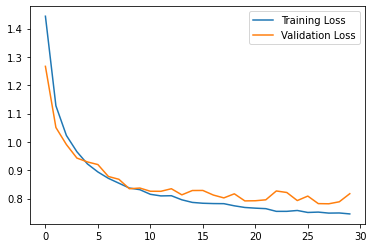

Name: Nazario          Label: Italian              Prediction: Italian          -- CORRECT
Name: Sakai            Label: Japanese             Prediction: Arabic           -- INCORRECT
Name: Makuda           Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Veselago         Label: Russian              Prediction: Russian          -- CORRECT
Name: Ryjkin           Label: Russian              Prediction: Russian          -- CORRECT
Name: Gastello         Label: Russian              Prediction: Spanish          -- INCORRECT
Name: Leck             Label: English              Prediction: English          -- CORRECT
Name: Vasin            Label: Russian              Prediction: Russian          -- CORRECT
Name: Matsuoka         Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Andreiko         Label: Russian              Prediction: Russian          -- CORRECT
Name: Hapsirokov       Label: Russian              Prediction: Russian          -- COR

In [19]:
model = ManualRNN(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

RNN(
  (rnn): RNN(87, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-07-31 11:16:03.701888

Epoch 0: Training Loss: 1.4277, Validation Loss: 1.2040
Epoch 1: Training Loss: 1.1403, Validation Loss: 1.1134
Epoch 2: Training Loss: 1.0680, Validation Loss: 1.0683
Epoch 3: Training Loss: 1.0217, Validation Loss: 1.0079
Epoch 4: Training Loss: 0.9801, Validation Loss: 0.9643
Epoch 5: Training Loss: 0.9458, Validation Loss: 0.9317
Epoch 6: Training Loss: 0.9110, Validation Loss: 0.8940
Epoch 7: Training Loss: 0.8824, Validation Loss: 0.9022
Epoch 8: Training Loss: 0.8550, Validation Loss: 0.8822
Epoch 9: Training Loss: 0.8324, Validation Loss: 0.8738
Epoch 10: Training Loss: 0.8105, Validation Loss: 0.8751
Epoch 11: Training Loss: 0.7886, Validation Loss: 0.8168
Epoch 12: Training Loss: 0.7734, Validation Loss: 0.8302
Epoch 13: Training Loss: 0.7566, Validation Loss: 0.8114
Epoch 14: Training Loss: 0.7457, Validation Lo

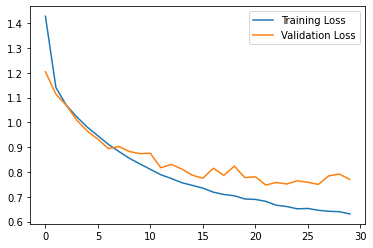

Name: Rahamimov        Label: Russian              Prediction: Russian          -- CORRECT
Name: Tulkin           Label: Russian              Prediction: Russian          -- CORRECT
Name: Ashbridge        Label: English              Prediction: English          -- CORRECT
Name: Roscoe           Label: English              Prediction: English          -- CORRECT
Name: Gatovsky         Label: Russian              Prediction: Russian          -- CORRECT
Name: Chamov           Label: Russian              Prediction: Russian          -- CORRECT
Name: Jemchujnikov     Label: Russian              Prediction: Russian          -- CORRECT
Name: Daher            Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Janson           Label: German               Prediction: English          -- INCORRECT
Name: Williams         Label: English              Prediction: English          -- CORRECT
Name: Tchekvin         Label: Russian              Prediction: Russian          -- CORRE

In [20]:
model = RNN(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

GRU(
  (rnn): GRU(87, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-07-31 13:51:43.185544

Epoch 0: Training Loss: 1.5993, Validation Loss: 1.4086
Epoch 1: Training Loss: 1.3189, Validation Loss: 1.2431
Epoch 2: Training Loss: 1.1847, Validation Loss: 1.1317
Epoch 3: Training Loss: 1.0976, Validation Loss: 1.0669
Epoch 4: Training Loss: 1.0406, Validation Loss: 1.0255
Epoch 5: Training Loss: 0.9969, Validation Loss: 1.0013
Epoch 6: Training Loss: 0.9653, Validation Loss: 0.9728
Epoch 7: Training Loss: 0.9349, Validation Loss: 0.9420
Epoch 8: Training Loss: 0.9043, Validation Loss: 0.9054
Epoch 9: Training Loss: 0.8747, Validation Loss: 0.8792
Epoch 10: Training Loss: 0.8491, Validation Loss: 0.8677
Epoch 11: Training Loss: 0.8248, Validation Loss: 0.8427
Epoch 12: Training Loss: 0.8005, Validation Loss: 0.8198
Epoch 13: Training Loss: 0.7745, Validation Loss: 0.8053
Epoch 14: Training Loss: 0.7508, Validation Lo

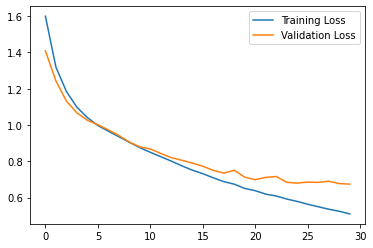

Name: Kearton          Label: English              Prediction: English          -- CORRECT
Name: Ochiai           Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Asfour           Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Ribeiro          Label: Portuguese           Prediction: Italian          -- INCORRECT
Name: Flannery         Label: English              Prediction: English          -- CORRECT
Name: Schoettmer       Label: German               Prediction: German           -- CORRECT
Name: Ajibana          Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Hatch            Label: English              Prediction: English          -- CORRECT
Name: Zhelaev          Label: Russian              Prediction: Russian          -- CORRECT
Name: Guttridge        Label: English              Prediction: English          -- CORRECT
Name: Hagiwara         Label: Japanese             Prediction: Japanese         -- CORRE

In [27]:
model = GRU(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)

LSTM(
  (rnn): LSTM(87, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)
2021-07-31 12:49:23.416452

Epoch 0: Training Loss: 1.7350, Validation Loss: 1.5581
Epoch 1: Training Loss: 1.4448, Validation Loss: 1.3904
Epoch 2: Training Loss: 1.2971, Validation Loss: 1.2318
Epoch 3: Training Loss: 1.1800, Validation Loss: 1.1352
Epoch 4: Training Loss: 1.1057, Validation Loss: 1.0588
Epoch 5: Training Loss: 1.0538, Validation Loss: 1.0394
Epoch 6: Training Loss: 1.0094, Validation Loss: 1.0037
Epoch 7: Training Loss: 0.9749, Validation Loss: 0.9735
Epoch 8: Training Loss: 0.9424, Validation Loss: 0.9504
Epoch 9: Training Loss: 0.9143, Validation Loss: 0.9367
Epoch 10: Training Loss: 0.8920, Validation Loss: 0.9005
Epoch 11: Training Loss: 0.8649, Validation Loss: 0.8887
Epoch 12: Training Loss: 0.8414, Validation Loss: 0.8428
Epoch 13: Training Loss: 0.8199, Validation Loss: 0.8293
Epoch 14: Training Loss: 0.8015, Validation 

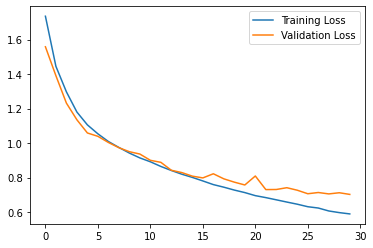

Name: Schlusser        Label: German               Prediction: German           -- CORRECT
Name: Balakirev        Label: Russian              Prediction: Russian          -- CORRECT
Name: Ozawa            Label: Japanese             Prediction: Japanese         -- CORRECT
Name: Chuhonkin        Label: Russian              Prediction: Russian          -- CORRECT
Name: Xing             Label: Chinese              Prediction: English          -- INCORRECT
Name: Quraishi         Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Oshin            Label: Japanese             Prediction: Russian          -- INCORRECT
Name: Fan              Label: Chinese              Prediction: Chinese          -- CORRECT
Name: Sakun            Label: Russian              Prediction: Russian          -- CORRECT
Name: Bazzi            Label: Arabic               Prediction: Arabic           -- CORRECT
Name: Healy            Label: English              Prediction: English          -- COR

In [26]:
model = LSTM(len(vocab), len(data)).to(device)
print(model)
train(model)
test(model)